In [1]:
from os import listdir
import scipy
from scipy.sparse import issparse
from IPython.display import display
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pickle
import matplotlib.pyplot as plt

In [2]:
def rearrange_results_df(df, metric = 'all'):
    # Separate lists for each category
    mean_cols_R2 = [name for name in df.index if name.endswith('mean_R2')]
    mean_cols_MSE = [name for name in df.index if name.endswith('mean_MSE')]
    
    var_cols_R2 = [name for name in df.index if name.endswith('var_R2')]
    var_cols_MSE = [name for name in df.index if name.endswith('var_MSE')]
    
    corr_cols_R2 = [name for name in df.index if name.endswith('corr_mtx_R2')]
    corr_cols_MSE = [name for name in df.index if name.endswith('corr_mtx_MSE')]
    
    cov_cols_R2 = [name for name in df.index if name.endswith('cov_mtx_R2')]
    cov_cols_MSE = [name for name in df.index if name.endswith('cov_mtx_MSE')]

    # Combine sorted lists with desired order
    if metric == 'all':
        new_order = mean_cols_R2 + mean_cols_MSE + var_cols_R2 + var_cols_MSE + corr_cols_R2 + corr_cols_MSE + cov_cols_R2 + cov_cols_MSE
    elif metric == 'MSE':
        new_order = mean_cols_MSE + var_cols_MSE + corr_cols_MSE + cov_cols_MSE
    elif metric == 'R2':
        new_order = mean_cols_R2 + var_cols_R2 + corr_cols_R2 + cov_cols_R2
    else:
        print(f'METRIC: {metric} IS NOT AN OPTION')
    # Reorder the dataframe based on the new order
    df = df.loc[new_order]

    return(df)

def are_identical(vals):
    return all(i == vals[0] for i in vals)

def df_to_heatmap(df, title, dims):
    fig, ax = plt.subplots(figsize=dims)    
    df.columns = [x.replace(' ', '\n') for x in df.columns]
    sns.heatmap(df, annot = df, linewidths=.5, ax=ax, cmap='Purples', fmt='0.4f', annot_kws={"size": 6}, cbar=False,
               xticklabels=True, yticklabels=True)
    
    ax.set_title(title, size=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.xaxis.set_ticks_position("top")

def plot_coverage_and_recall(coverage_results, recall_results, dims):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=dims)

    # Plotting Coverage on the first subplot
    ax1.plot(coverage_results, label=coverage_results.columns)
    # Plotting Recall on the second subplot
    ax2.plot(recall_results, label=recall_results.columns)
    
    # Adding titles and labels for the Coverage plot
    ax1.set_title("Coverage by Model")
    ax1.set_xlabel("p-value threshold")
    ax1.set_ylabel("Coverage")
    #ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adding titles and labels for the Recall plot
    ax2.set_title("Recall by Model")
    ax2.set_xlabel("p-value threshold")
    ax2.set_ylabel("Recall")
    ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def get_variable_and_fixed_params(all_results):
    all_config_params = {}
    for key, val in all_results.items():
        for config_key, config_val in val['config'].items():
            if config_key in all_config_params:
                all_config_params[config_key].append(config_val)
            else:
                all_config_params[config_key] = [config_val]
    
    fixed_params = []
    variable_params = []
    for key, val in all_config_params.items():
        if are_identical(val) or len(val) < len(all_results_concat_dict):
            fixed_params.append(key)
        else:
            print(f'Config parameter "{key}" varies with values:\n {val}')
            variable_params.append(key)
    print(f'\nThe following parameters are fixed for all runs:\n {fixed_params}')

    return fixed_params, variable_params

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
import json
import pickle
with open('/orcd/archive/abugoot/001/Projects/njwfish/sandbox/scripts/eval_locations.json') as json_file:
    eval_locs = json.load(json_file)

In [5]:
eval_locs

{'Satija_TGFB_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/Satija_TGFB_HVG.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_TGFB_HVG',
   'scGen': '/orcd/archive/abugoot/001/Projects/dlesman/sandbox/scGen/Satija_TGFB_HVG'}},
 'kaggle_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/kaggle_HVG.h5ad',
  'results_location': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/kaggle_HVG'},
 'Satija_IFNB_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/Satija_IFNB_HVG.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG'}},
 'nault': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/nault.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/nault'}}}

In [6]:
NAME_OF_DATA = 'Satija_IFNB_HVG'
# NAME_OF_DATA = 'nault'
path_to_results = eval_locs[NAME_OF_DATA]['results_location']
#result_dirs = [f'{path_to_results}/{x}' for x in listdir(path_to_results)]
result_dirs = [f'{path_to_results[x]}/{y}' for x in path_to_results for y in listdir(path_to_results[x])]

In [7]:
r2_and_mse_concat_dict = {}
c_r_results_concat_dict = {}
DEGs_overlaps_concat_dict = {}

In [8]:
all_results_concat_dict = {}

In [9]:
ROUNDED = False

In [10]:
result_dirs

['/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG/de10120a66a7723b094feeab2b924b6c3b1ea1f266b2fb4ecf33721289011c82',
 '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG/b4ebe4e18458a9308990b8189f4f0304e1dc750f0673b46375a261aa590f7593',
 '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG/3d8f63b3a5c857a8526e5c868ba973a698cf81002b86160d47f080fba45bb037',
 '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG/6dd160a9f5f2fa7c0e1cc8953dcae846c80c5fd382330a49a3bf3245a36539ac',
 '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG/llm']

In [11]:
with open(f'{result_dirs[-1]}/config.json') as json_file:
    config = json.load(json_file)

In [12]:
config

{'batch_size': 32,
 'max_epochs': 100,
 'model_kwargs': {'w1': 64, 'w2': 64},
 'dataset': 'Satija_IFNB_HVG',
 'control_pert': 'NT',
 'holdout_cells': ['HT29'],
 'holdout_perts': ['USP18'],
 'cell_col': 'cell_type',
 'pert_col': 'gene',
 's': True,
 'exclude_ct': False,
 'embedding': 'standard',
 'arch': 'cmha',
 'model_type': 'llm'}

In [13]:
eval_locs

{'Satija_TGFB_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/Satija_TGFB_HVG.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_TGFB_HVG',
   'scGen': '/orcd/archive/abugoot/001/Projects/dlesman/sandbox/scGen/Satija_TGFB_HVG'}},
 'kaggle_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/kaggle_HVG.h5ad',
  'results_location': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/kaggle_HVG'},
 'Satija_IFNB_HVG': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/Satija_IFNB_HVG.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/Satija_IFNB_HVG'}},
 'nault': {'data_location': '/orcd/archive/abugoot/001/Projects/dlesman/datasets/nault.h5ad',
  'results_location': {'cfm': '/orcd/archive/abugoot/001/Projects/njwfish/sandbox/cfm/nault'}}}

In [14]:
for directory in result_dirs:
    with open(f'{directory}/config.json') as json_file:
        config = json.load(json_file)
    
    for holdout_pert, holdout_cell in zip(config["holdout_perts"], config["holdout_cells"]):
        r2_mse_filename = f'r2_and_mse_{holdout_pert}_{holdout_cell}.pkl' if not ROUNDED else f'r2_and_mse_rounded_{holdout_pert}_{holdout_cell}.pkl'
        c_r_filename = f'c_r_results_{holdout_pert}_{holdout_cell}.pkl' if not ROUNDED else f'c_r_results_rounded_{holdout_pert}_{holdout_cell}.pkl'
        DEGs_overlap_filename = f'DEGs_overlaps_{holdout_pert}_{holdout_cell}.pkl' if not ROUNDED else f'DEGs_overlaps_rounded_{holdout_pert}_{holdout_cell}.pkl'
        results_exist = ((r2_mse_filename in listdir(directory)) & (c_r_filename in listdir(directory)) & (DEGs_overlap_filename in listdir(directory)))
        if results_exist:
            print(holdout_pert)
            # if ((len(config['holdout_perts']) == 1) and (len(config['holdout_cells']) == 1)):                     
            with open(f'{directory}/{r2_mse_filename}', 'rb') as f:
                r2_and_mse = pickle.load(f)
                
            with open(f'{directory}/{c_r_filename}', 'rb') as f:
                c_r_results = pickle.load(f)
                
            with open(f'{directory}/{DEGs_overlap_filename}', 'rb') as f:
                DEGs_overlaps = pickle.load(f)
    
            result_name = f'{directory.split("/")[-1]}_{holdout_pert}_{holdout_cell}'
            all_results_concat_dict[result_name] = {}
            all_results_concat_dict[result_name]['r2_and_mse'] =  r2_and_mse
            all_results_concat_dict[result_name]['c_r_results'] = c_r_results
            all_results_concat_dict[result_name]['DEGs_overlaps'] = DEGs_overlaps
            all_results_concat_dict[result_name]['config'] = config

USP18
USP18
USP18
USP18


In [15]:
all_results_concat_dict

{'de10120a66a7723b094feeab2b924b6c3b1ea1f266b2fb4ecf33721289011c82_USP18_HT29': {'r2_and_mse': {'all_genes_mean_R2': 0.9532746437052059,
   'all_genes_var_R2': 0.9422896446848106,
   'all_genes_mean_MSE': 0.002447066353583087,
   'all_genes_var_MSE': 0.0009042064696211805,
   'all_genes_corr_mtx_R2': 0.28840490562304794,
   'all_genes_cov_mtx_R2': 0.6752001843282164,
   'all_genes_corr_mtx_MSE': 0.0014937782977099035,
   'all_genes_cov_mtx_MSE': 4.763669228577399e-06,
   'Top_209_DEGs_mean_R2': 0.863725717940944,
   'Top_209_DEGs_var_R2': 0.827103685325026,
   'Top_209_DEGs_mean_MSE': 0.021117824004217817,
   'Top_209_DEGs_var_MSE': 0.0061570003212056456,
   'Top_209_DEGs_corr_mtx_R2': 0.7090323777214252,
   'Top_209_DEGs_cov_mtx_R2': 0.7159935539951608,
   'Top_209_DEGs_corr_mtx_MSE': 0.0021866119644434506,
   'Top_209_DEGs_cov_mtx_MSE': 0.00015385829190707386,
   'Top_100_DEGs_mean_R2': 0.7771934154082155,
   'Top_100_DEGs_var_R2': 0.7394041957619512,
   'Top_100_DEGs_mean_MSE': 0.04

In [16]:
fixed_params, variable_params = get_variable_and_fixed_params(all_results_concat_dict)

Config parameter "model_type" varies with values:
 ['flow', 'nearest_cell_type', 'flow', 'llm']

The following parameters are fixed for all runs:
 ['batch_size', 'max_epochs', 'model_kwargs', 'dataset', 'control_pert', 'holdout_cells', 'holdout_perts', 'cell_col', 'pert_col', 's', 'exclude_ct', 'embedding', 'arch', 'fm']


In [18]:
PERT_OF_INTEREST = 'perturbed'
PERT_OF_INTEREST = 'USP18'

In [19]:
DEG_overlap_df_dict = {}
r2_and_mse_df_dict = {}
c_df_dict = {}
r_df_dict = {}
for key, val in all_results_concat_dict.items():
    if val['config']['holdout_perts'][0] == PERT_OF_INTEREST:
        
        condition_name = ' '.join([str(val['config'][x]) for x in variable_params])
        
        eval_DEGs_df = pd.DataFrame({condition_name: val['DEGs_overlaps'].values()},
                                index = list(val['DEGs_overlaps'].keys()))
        DEG_overlap_df_dict[condition_name] = eval_DEGs_df


        r2_and_mse_df = pd.DataFrame({condition_name: val['r2_and_mse'].values()},
                                index = list(val['r2_and_mse'].keys()))
        r2_and_mse_df_dict[condition_name] = r2_and_mse_df


        c_df = pd.DataFrame({condition_name: [x[0] for x in val['c_r_results'].values()]},
                                index = list(val['c_r_results'].keys()))
        c_df_dict[condition_name] = c_df

        r_df = pd.DataFrame({condition_name: [x[1] for x in val['c_r_results'].values()]},
                                index = list(val['c_r_results'].keys()))
        r_df_dict[condition_name] = r_df


DEG_results_summary = pd.concat(DEG_overlap_df_dict.values(),axis=1)
r2_and_mse_results_summary = pd.concat(r2_and_mse_df_dict.values(),axis=1)
c_results_summary = pd.concat(c_df_dict.values(),axis=1)
r_results_summary = pd.concat(r_df_dict.values(),axis=1)

In [20]:
DEG_results_summary

,flow,nearest_cell_type,llm
Overlap_in_top_209_DEGs,2.0,0.0,NaN
Overlap_in_top_100_DEGs,0.0,0.0,0.0
Overlap_in_top_50_DEGs,0.0,0.0,0.0
Overlap_in_top_20_DEGs,0.0,0.0,0.0
Overlap_in_top_220_DEGs,NaN,NaN,2.0


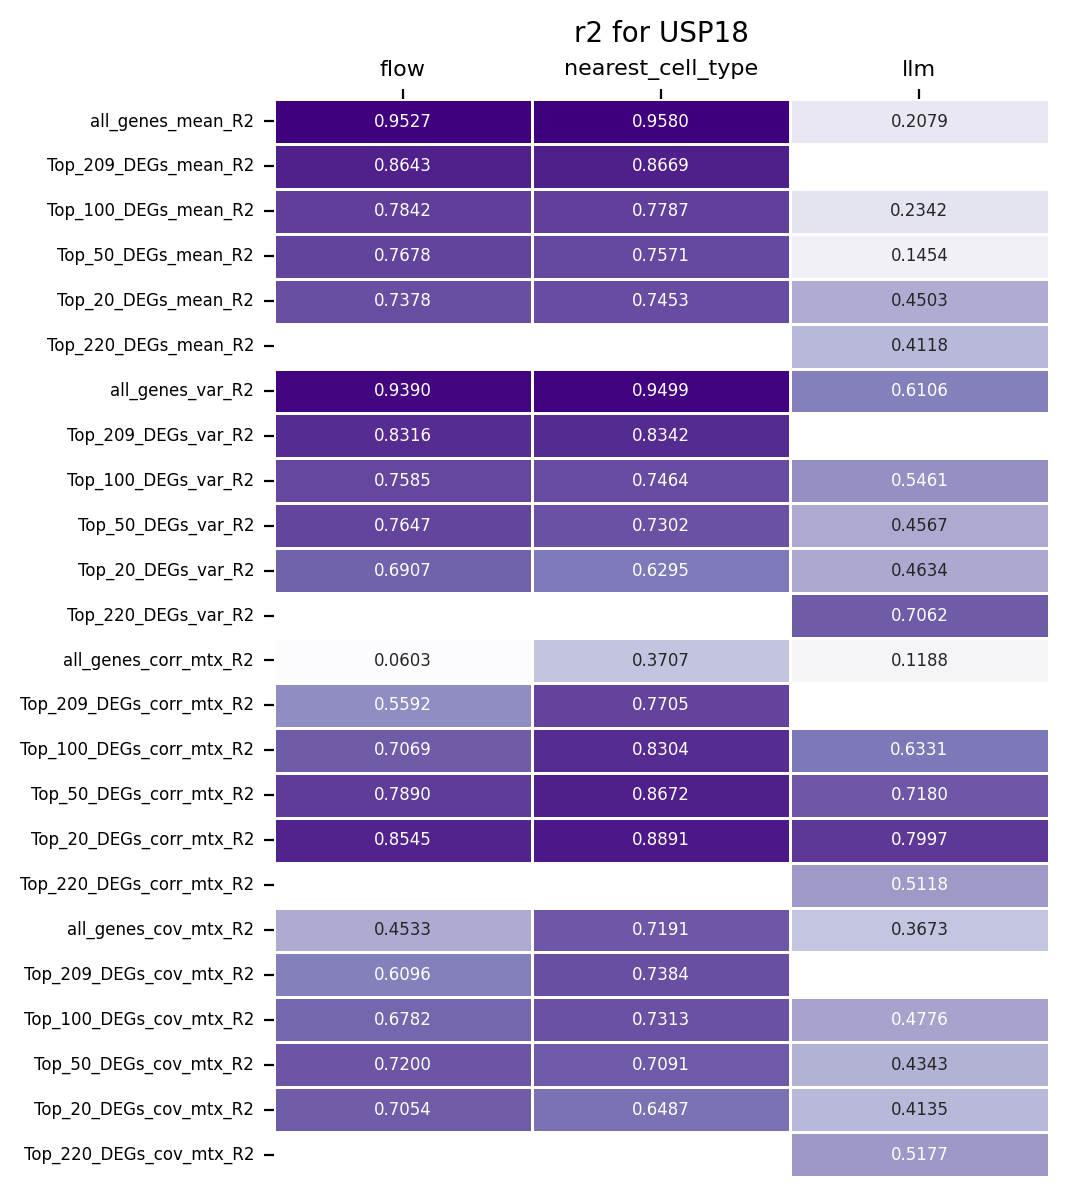

In [21]:
df_to_heatmap(rearrange_results_df(r2_and_mse_results_summary, metric = 'R2'), f'r2 for {PERT_OF_INTEREST}', (5,7))

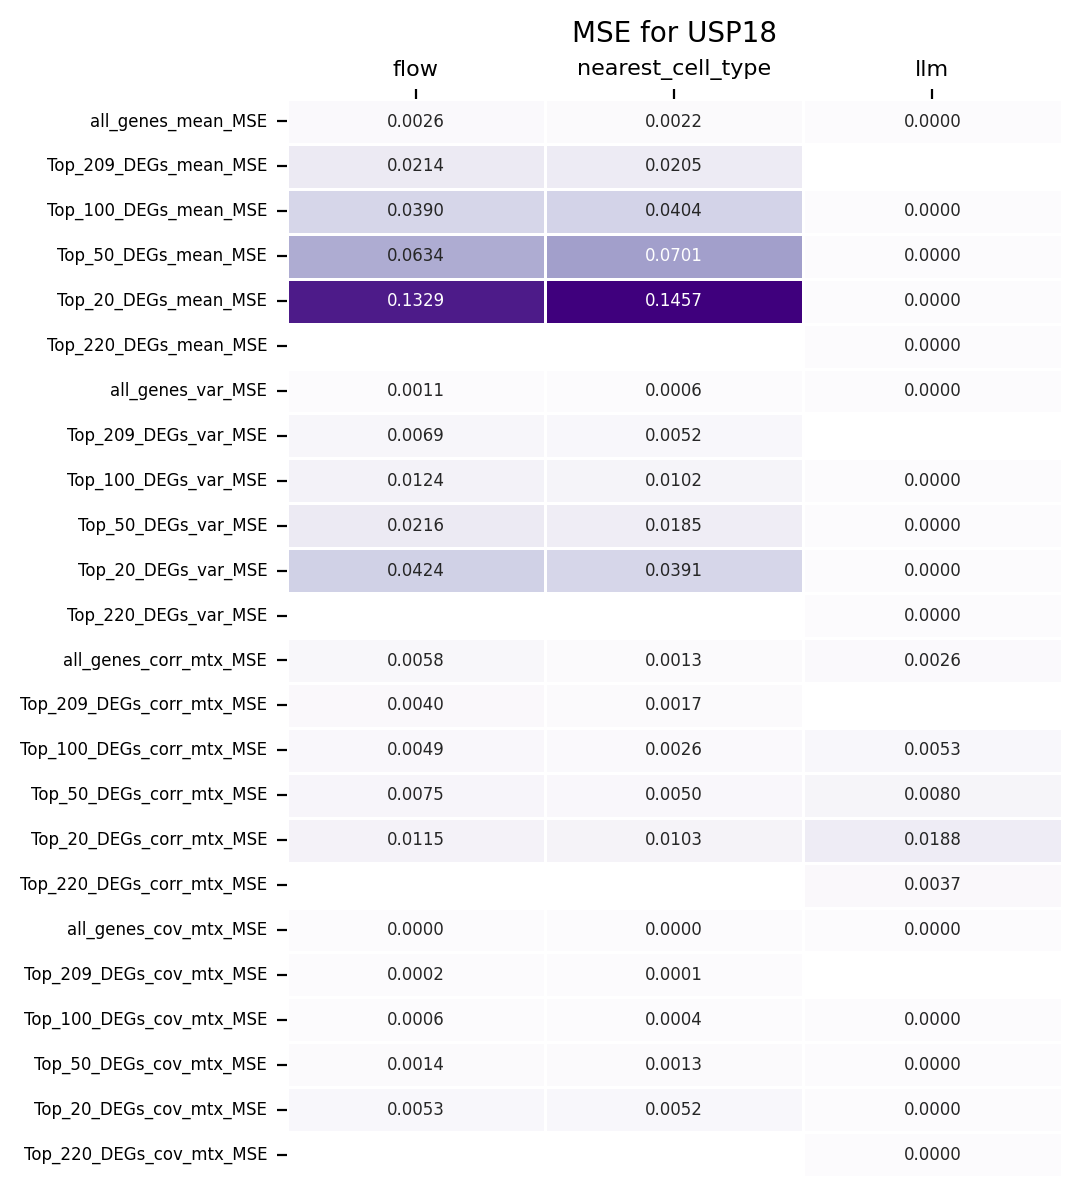

In [22]:
df_to_heatmap(rearrange_results_df(r2_and_mse_results_summary, metric = 'MSE'), f'MSE for {PERT_OF_INTEREST}', (5,7))

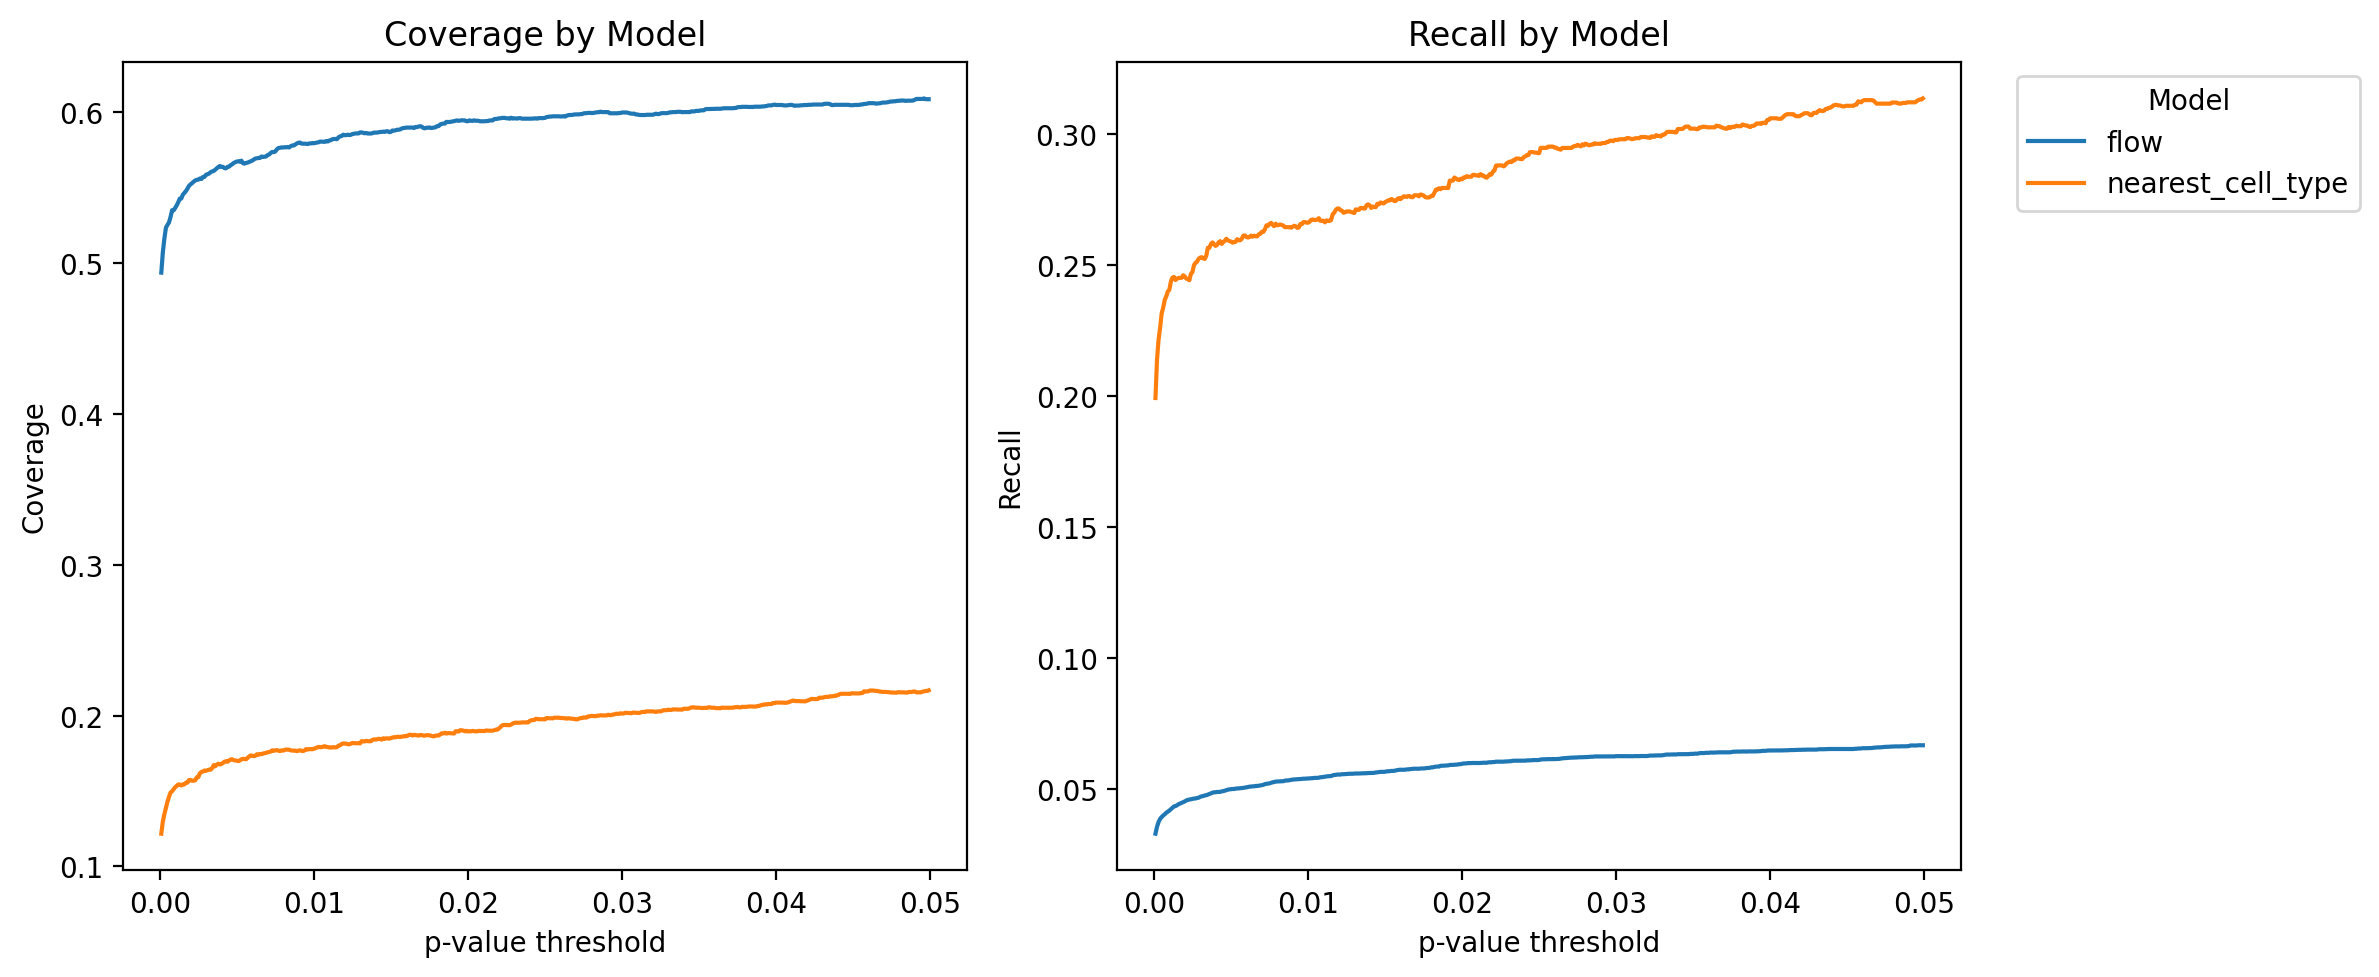

In [29]:
plot_coverage_and_recall(c_results_summary, r_results_summary, (12,5))